# Prototype for the function that build up the connections.
This is a prototype for the function *create_connections* found in the file **network.py**.

This is version 0.1.

The notebook does not consider the waves as different time points.

#### Changes in 06/02/2018

* The connections are based in 3 different setups: all questions, GEN questions and friendship question alone
* Verifying if Wave 4 affects the results of the 3 former waves. Prioritizing the Y1 for the network. There are **NO NOMINATIONS ON W4**.

**Last update:** 06/02/2018

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
%matplotlib inline

# Read nominations file
Get the nominations file from the data folder. The original file was modified. The columns were changed to:
```
nominations.columns = ['class', 'child', 'wave', 'variable', 'class_nominated', 'nominated', 'same_class']
```


In [3]:
data_f='./data/'
nominations = pd.read_csv(data_f+'nominations.csv', sep=';', header=0)

In [4]:
nominations.head()

,class,child,wave,variable,class_nominated,nominated,same_class
0,52,643,1,PA_Impression_Management,NaN,633,0
1,52,645,1,ME_Com_Network,NaN,633,0
2,52,645,1,GEN_Leader,NaN,633,0
3,52,648,1,GEN_Friendship,NaN,633,0
4,52,648,1,GEN_Want2B,NaN,633,0


In [5]:
nominations[nominations.wave == 4]

,class,child,wave,variable,class_nominated,nominated,same_class


# Variables present in the file
The variables collected in this file are presented below.

In [6]:
set(nominations.variable)

{'DI_Com_Network',
 'DI_Impression_management',
 'DI_Modelling',
 'GEN_Advice',
 'GEN_Friendship',
 'GEN_Leader',
 'GEN_Respect',
 'GEN_Social_Facilitation',
 'GEN_Want2B',
 'ME_Com_Network',
 'PA_Com_Network',
 'PA_Impression_Management',
 'PA_Modelling'}

# Read the formula for the weights of each question
The JSON file is a dictionary containing the information of which questions should be taken into consideration and how much they value for the overall calculation of the connections.

max_score is the maximum weight a nomination can have. That means that if one person nominates another person in all the questions, it will reach a value of 1 for the connection strenght.

In [7]:
setups_list = ['all', 'gen', 'friendship']
formula_list = []

for setup in setups_list:
    formula_list.append(json.loads(open(('./settings/connections_{0}.json').format(setup)).read()))

In [8]:
formula_list

[{'DI_Com_Network': 1,
  'DI_Impression_management': 1,
  'DI_Modelling': 1,
  'GEN_Advice': 1,
  'GEN_Friendship': 1,
  'GEN_Leader': 1,
  'GEN_Respect': 1,
  'GEN_Social_Facilitation': 1,
  'GEN_Want2B': 1,
  'ME_Com_Network': 1,
  'PA_Com_Network': 1,
  'PA_Impression_Management': 1,
  'PA_Modelling': 1},
 {'DI_Com_Network': 0,
  'DI_Impression_management': 0,
  'DI_Modelling': 0,
  'GEN_Advice': 1,
  'GEN_Friendship': 1,
  'GEN_Leader': 1,
  'GEN_Respect': 1,
  'GEN_Social_Facilitation': 1,
  'GEN_Want2B': 1,
  'ME_Com_Network': 0,
  'PA_Com_Network': 0,
  'PA_Impression_Management': 0,
  'PA_Modelling': 0},
 {'DI_Com_Network': 0,
  'DI_Impression_management': 0,
  'DI_Modelling': 0,
  'GEN_Advice': 0,
  'GEN_Friendship': 1,
  'GEN_Leader': 0,
  'GEN_Respect': 0,
  'GEN_Social_Facilitation': 0,
  'GEN_Want2B': 0,
  'ME_Com_Network': 0,
  'PA_Com_Network': 0,
  'PA_Impression_Management': 0,
  'PA_Modelling': 0}]

In [9]:
max_score_list = []

for formula in formula_list:
    max_score_list.append(sum(formula.values()))

max_score_list

[13, 6, 1]

# Building a dictionary of nominations

The idea is to build a dictionary with the list of nominations of each child and the final weight. The final result should be something like shown below:

```json
{
    child1: {
            nominated1: weight1,
            nominated2: weight2,
            ...
            nominatedx: weightx,
           },
    child2: {
            nominated1: weight1,
            nominated2: weight2,
            ...
            nominatedx: weightx,
           },
    ...
    childx: {
            nominated1: weight1,
            nominated2: weight2,
            ...
            nominatedx: weightx,
           }
}
```

# List of participants
*pp.csv* provides the list of the participants and the waves they were part of the experiment.

In [10]:
pp = pd.read_csv(data_f+'pp.csv', sep=';', header=0)
pp.head()

,School,Primary,Secondary,Class_Y1,Class_Y2,Child_Bosse,parti_W1,parti_W2,parti_W3,parti_W4
0,22,NaN,1.0,52.0,52.0,643,1,0,0,0
1,22,NaN,1.0,52.0,52.0,645,1,0,0,0
2,22,NaN,1.0,52.0,52.0,648,1,0,0,0
3,22,NaN,1.0,52.0,55.0,649,1,1,0,1
4,22,NaN,1.0,52.0,55.0,650,1,1,0,1


# Build empty dictionary for all the kids (953)

In [11]:
connections_dict_all = {}
connections_dict_gen = {}
connections_dict_friend = {}

for child in list(pp.Child_Bosse):
    connections_dict_all[child] = {}
    connections_dict_gen[child] = {}
    connections_dict_friend[child] = {}

# Create nomination list

This version does not consider differences between waves. That is, Waves 1, 2 and 3 are all valid. Wave 4 does not have any information.

In [12]:
# To avoid repetition
nominations_list = []

for line in nominations[['child', 'nominated', 'variable']].iterrows():
    (ch, nom, var) = line[1]
    #print(ch, nom, var)
    #print('weigh: ' , formula[var])

    # Verify if nominated is in the list of participants (pp)
    if nom in list(pp.Child_Bosse) and (ch, nom, var) not in nominations_list:
        # Add value in the key
        connections_dict_all[ch][nom] = connections_dict_all[ch].get(nom, 0) + 1*formula_list[0][var]
        connections_dict_gen[ch][nom] = connections_dict_gen[ch].get(nom, 0) + 1*formula_list[1][var]
        connections_dict_friend[ch][nom] = connections_dict_friend[ch].get(nom, 0) + 1*formula_list[2][var]
        nominations_list.append((ch, nom, var))


In [13]:
pd.DataFrame(connections_dict_all).values

array([[nan,  1.,  4., ..., nan, nan, nan],
       [ 2., nan,  4., ..., nan, nan, nan],
       [ 2.,  3., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [14]:
pd.DataFrame(connections_dict_gen).values

array([[nan,  0.,  3., ..., nan, nan, nan],
       [ 0., nan,  3., ..., nan, nan, nan],
       [ 0.,  2., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [15]:
pd.DataFrame(connections_dict_friend).values

array([[nan,  0.,  1., ..., nan, nan, nan],
       [ 0., nan,  1., ..., nan, nan, nan],
       [ 0.,  0., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

# Create a data frame of the connections

The data frame created is 901x953. That means that not all the students have data from their nominations.

The missing values receive 0, and the entire data frame is divided by the maximum score to normalize the values between 0 and 1.

In [16]:
# can be skipped if the division happens when the edges are being inserted.
connections_all_df = pd.DataFrame(connections_dict_all).fillna(0)/max_score_list[0]
connections_gen_df = pd.DataFrame(connections_dict_gen).fillna(0)/max_score_list[1]
connections_friend_df = pd.DataFrame(connections_dict_friend).fillna(0)/max_score_list[2]

In [17]:
print(connections_all_df.shape, connections_gen_df.shape, connections_friend_df.shape)

(901, 953) (901, 953) (901, 953)


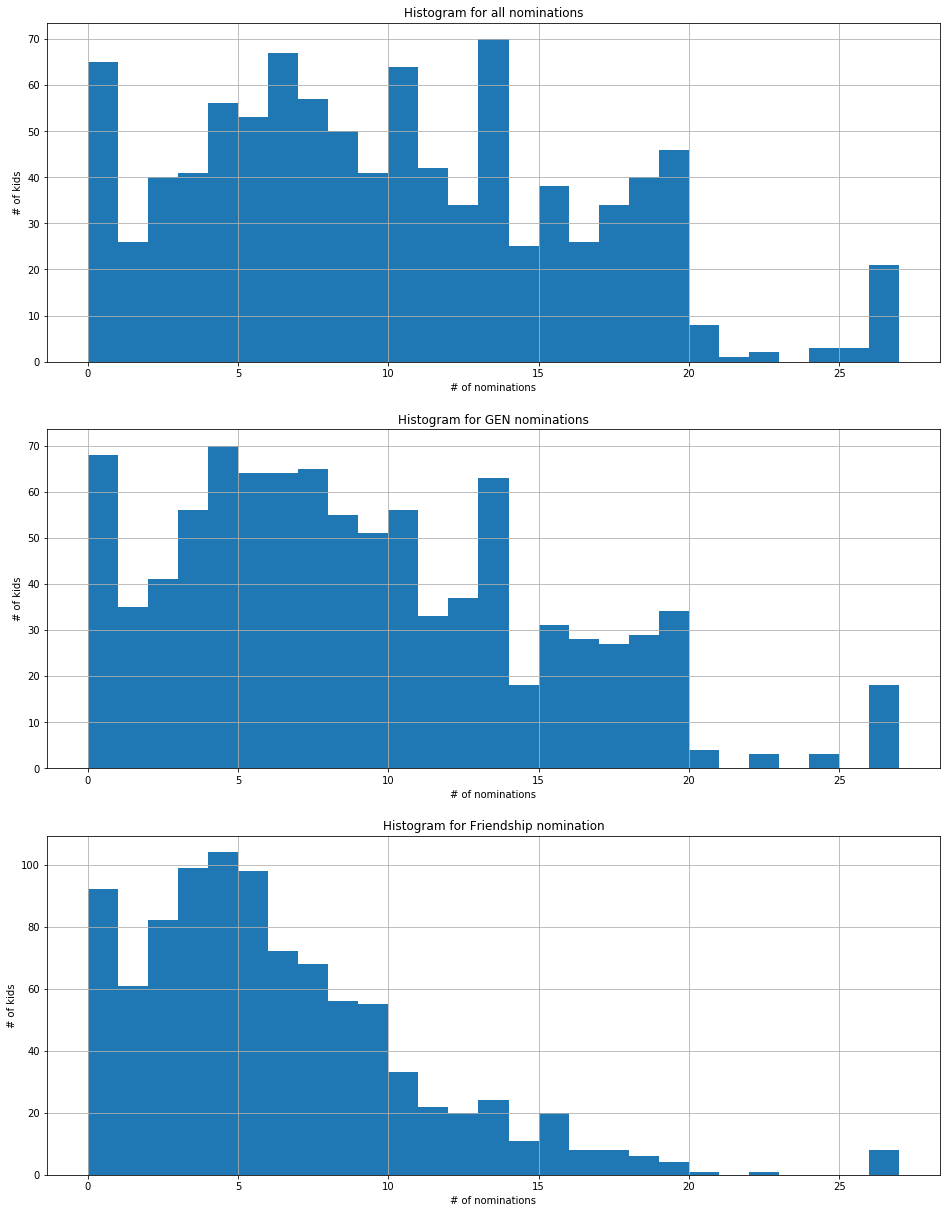

In [18]:

plt.figure(1)

plt.subplot(3,1,1)
connections_all_df[connections_all_df > 0].count().hist(bins=27, figsize=((16,8)))
plt.title('Histogram for all nominations')
plt.ylabel('# of kids')
plt.xlabel('# of nominations')

plt.subplot(3,1,2)
connections_gen_df[connections_gen_df > 0].count().hist(bins=27, figsize=((16,8)))
plt.title('Histogram for GEN nominations')
plt.ylabel('# of kids')
plt.xlabel('# of nominations')

plt.subplot(3,1,3)

# Histogram of nominations per kid
connections_friend_df.sum().hist(bins=27, figsize=((16,8)))
plt.title('Histogram for Friendship nomination')
plt.ylabel('# of kids')
plt.xlabel('# of nominations')

plt.subplots_adjust(left=None, bottom=0, right=None, top=2.0, wspace=None, hspace=None)


In [19]:
# Histogram of nominations per kid
#connections_all_df[connections_all_df > 0].count().hist(bins=27, figsize=((16,8)))
#plt.title('Histogram for all nominations')
#plt.ylabel('# of kids')
#plt.xlabel('# of nominations')

In [20]:
# Histogram of nominations per kid
#connections_gen_df[connections_gen_df > 0].count().hist(bins=27, figsize=((16,8)))
#plt.title('Histogram for GEN nominations')
#plt.ylabel('# of kids')
#plt.xlabel('# of nominations')

In [21]:
# Histogram of nominations per kid
#connections_friend_df.sum().hist(bins=27, figsize=((16,8)))
#plt.title('Histogram for Friendship nomination')
#plt.ylabel('# of kids')
#plt.xlabel('# of nominations')

# Build graph
The normalized data is transformed again to dictionary.

The items give the values for the edges and the weight of the connections.

In [22]:
connections_all_dict = connections_all_df.to_dict()
connections_gen_dict = connections_gen_df.to_dict()
connections_friend_dict = connections_friend_df.to_dict()

In [23]:
graph_all = nx.DiGraph()
graph_gen = nx.DiGraph()
graph_friend = nx.DiGraph()

In [24]:
for node in connections_all_dict.items():
    destine = node[0]
    origins = node[1]
    for peer, weight in origins.items():
        if weight > 0:
            graph_all.add_edge(peer, destine, weight=weight)
            
for node in connections_gen_dict.items():
    destine = node[0]
    origins = node[1]
    for peer, weight in origins.items():
        if weight > 0:
            graph_gen.add_edge(peer, destine, weight=weight)
            
for node in connections_friend_dict.items():
    destine = node[0]
    origins = node[1]
    for peer, weight in origins.items():
        if weight > 0:
            graph_friend.add_edge(peer, destine, weight=weight)

In [25]:
# Number of edges in each graph
print(len(graph_all.edges()), len(graph_gen.edges()), len(graph_friend.edges()))

9154 8304 5562


# Save information of the edges

The results are saved in the file *connections.csv* in the **results** folder.

The graph has 9.042 edges based on the data provided.

In [26]:
connections_all_df.to_csv('./results/connections_all.csv')
connections_gen_df.to_csv('./results/connections_gen.csv')
connections_friend_df.to_csv('./results/connections_friend.csv')